In [1]:
import sys
import os
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
#去除没有必要的警告
import warnings
warnings.filterwarnings(action="ignore",message="internal gelsd")
# 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号, 注意['SimHei']对应这句不行
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#画图函数
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
#生成数据
X_train = generate_3d_data(60)
X_train.shape

(60, 3)

In [4]:
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
#编码器
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])#输入3维，输出2维
#解码器
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])#输入2维，输出3维
#自动编码器=编码器+解码器
autoencoder = keras.models.Sequential([encoder, decoder])

In [6]:
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5)) 
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2153
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0514
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0460
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0805
Epoch 11/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0432
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [7]:
codings = encoder.predict(X_train)
codings.shape

2/2 [==============================] - 0s 1ms/step


(60, 2)

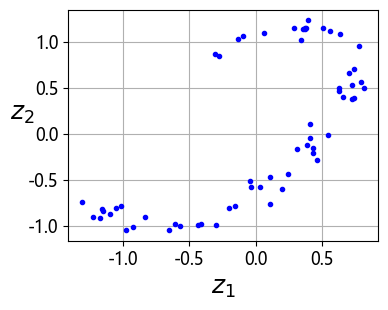

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
#save_fig("linear_autoencoder_pca_plot")
plt.show()

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 2s 0us/step


In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

#编码器
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),#编码器使用28*28的灰度像素，并将其展平
    #每个图像的大小为28*28=784
    keras.layers.Dense(100, activation="selu"),#通过两个尺寸递减的隐藏层处理这些向量
    keras.layers.Dense(30, activation="selu"),#使用selu激活函数，最后输出30的向量
])

#解码器
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),#输入长度为30的向量
    keras.layers.Dense(28 * 28, activation="sigmoid"),#输出是28*28的向量
    keras.layers.Reshape([28, 28])#将向量变成图片
])

#自动编码器
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), 
                   metrics=[rounded_accuracy])
#loss="binary_crossentropy"表明使用二元交叉熵损失来代替均方误差（对应像素做差）
#这样做，收敛的更快

In [12]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3376 - rounded_accuracy: 0.8871 - val_loss: 0.3164 - val_rounded_accuracy: 0.9003
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3058 - val_rounded_accuracy: 0.9190
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2990 - rounded_accuracy: 0.9210 - val_loss: 0.2984 - val_rounded_accuracy: 0.9205
Epoch 4/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2950 - rounded_accuracy: 0.9245 - val_loss: 0.2944 - val_rounded_accuracy: 0.9270
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2924 - rounded_accuracy: 0.9269 - val_loss: 0.2932 - val_rounded_accuracy: 0.9275
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2907 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

1/1 [==============================] - 0s 70ms/step


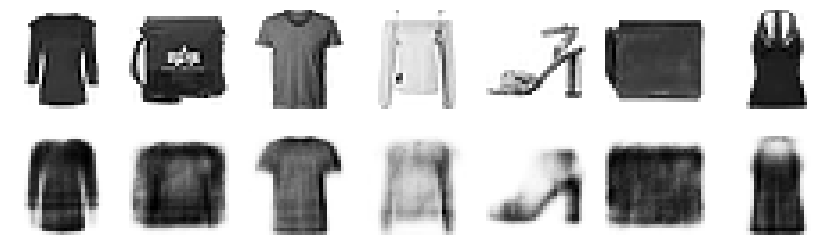

In [13]:
#定义可视化函数
def show_reconstructions(model, images=X_valid, n_images=7):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))#留出的位置
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)#第一行显示原本的验证集上的图片
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)#第二行显示预测生成的图片
        plot_image(reconstructions[image_index])
show_reconstructions(stacked_ae)